In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk

## Clustering de semillas

In [14]:
SEED = 100495861

In [15]:
df = pd.read_csv('semillas.csv')
df.sample(5)

,area,perimetro,compacidad,longitud,anchura,asimetria,surco,clase
73,19.11,16.26,0.9081,6.154,3.930,2.936,6.079,2
118,18.89,16.23,0.9008,6.227,3.769,3.639,5.966,2
147,12.49,13.46,0.8658,5.267,2.967,4.421,5.002,3
189,10.59,12.41,0.8648,4.899,2.787,4.975,4.794,3
209,12.30,13.34,0.8684,5.243,2.974,5.637,5.063,3


In [16]:
df.describe()

,area,perimetro,compacidad,longitud,anchura,asimetria,surco,clase
count,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000
mean,14.847524,14.559286,0.870999,5.628533,3.258605,3.700201,5.408071,2.000000
std,2.909699,1.305959,0.023629,0.443063,0.377714,1.503557,0.491480,0.818448
min,10.590000,12.410000,0.808100,4.899000,2.630000,0.765100,4.519000,1.000000
25%,12.270000,13.450000,0.856900,5.262250,2.944000,2.561500,5.045000,1.000000
50%,14.355000,14.320000,0.873450,5.523500,3.237000,3.599000,5.223000,2.000000
75%,17.305000,15.715000,0.887775,5.979750,3.561750,4.768750,5.877000,3.000000
max,21.180000,17.250000,0.918300,6.675000,4.033000,8.456000,6.550000,3.000000


A partir de este estudio simple, se puede identificar que:
- Existen un máximo de tres clases
- El resto de los datos son floats, se necesita una mayor investigación.
- 
Para comprobar los PCAs, debemos de sacar X e Y

In [17]:
X = df.drop(columns=["clase"])
y = df["clase"]

print(X.shape, X.columns)
print(y.shape)

(210, 7) Index(['area', 'perimetro', 'compacidad', 'longitud', 'anchura', 'asimetria',
       'surco'],
      dtype='object')
(210,)


## Comprobar los scalers

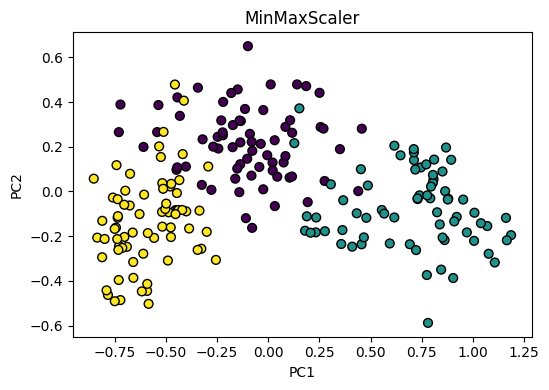

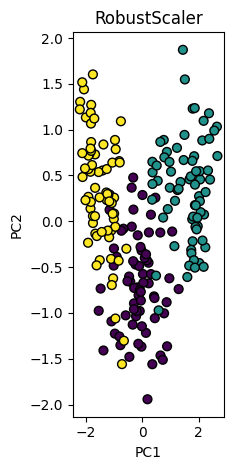

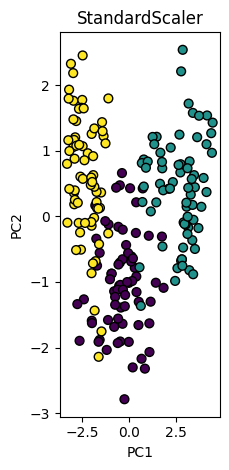

In [23]:
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

scalers = [MinMaxScaler(), RobustScaler(), StandardScaler()]
scaler_names = ["MinMaxScaler", "RobustScaler", "StandardScaler"]

plt.figure(figsize=(15, 4))

for i, (scaler, name) in enumerate(zip(scalers, scaler_names)):
    pipe = Pipeline([
        ("scaler", scaler),
        ("pca", PCA(n_components=2))
    ])
    X_reduced = pipe.fit_transform(X)

    plt.subplot(1, 3, i + 1)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, cmap="viridis", edgecolor="k", s=40)
    plt.title(name)
    plt.xlabel("PC1")
    plt.ylabel("PC2")

    plt.tight_layout()
    plt.show()

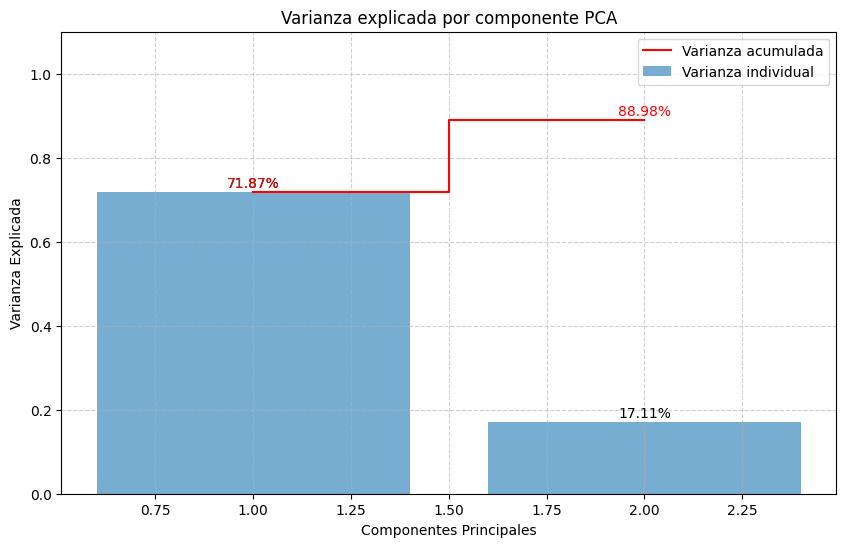

In [25]:
# Varianza explicada y acumulada
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)
    
# 1. Plot de Varianza Explicada y Acumulada
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.6, label='Varianza individual')
plt.step(range(1, len(cumulative_variance) + 1), cumulative_variance, where='mid', label='Varianza acumulada', color='red')
# Añadir valores exactos
for i, (ev, cv) in enumerate(zip(explained_variance, cumulative_variance)):
    plt.text(i + 1, ev + 0.01, f"{ev:.2%}", ha='center')
    plt.text(i + 1, cv + 0.01, f"{cv:.2%}", ha='center', color='red')
    
plt.xlabel('Componentes Principales')
plt.ylabel('Varianza Explicada')
plt.title('Varianza explicada por componente PCA')
plt.legend(loc='best')
plt.ylim(0, 1.1)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

Ojo avizor, parece que no hay mucha diferencia pero parece que con MinMaxScaler se encuentra todo mucho mejor agrupado que de normal. Tiraremos de ese hilo.

Además, somos capaces de explicar el **89% de la varianza** con solo dos componentes. Esto es muy importante de destacar, ya que podremos conseguir una serie de resultados muy buenos.

## Aplicación de técnicas

Se usarán:

- K-means
- Hierarchical
- DBScan

### K-means

Antes de todo, vamos a ejecutar una instancia de K-means sin ajuste de hiper-parámetros para ver el resultado.

In [58]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import scale
from sklearn.metrics import silhouette_score, silhouette_samples

scaler = MinMaxScaler()
pipe = Pipeline([
    ("scaler", scaler),
    ("pca", PCA(n_components=2))
])
X_reduced = pipe.fit_transform(X)

modelo_kmeans = KMeans(n_clusters=3,  random_state=SEED)
modelo_kmeans.fit(X=X_scaled)

KMeans(n_clusters=3, random_state=100495861)

In [ ]:
modelo_kmeans.cl 

In [64]:
def plot_kmeans_2d(X_2d, y_true, modelo_kmeans):
    """
    Representa en un subplot los labels reales y en el otro los clusters KMeans
    (junto a sus centroides). 
    - X_2d: array (n_samples, 2) con tus dos componentes.
    - y_true: etiquetas reales.
    - modelo_kmeans: modelo KMeans ya ajustado a X_2d.
    """

    y_pred = modelo_kmeans.predict(X_2d)
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    # 1) Grupos “verdaderos”
    for label in np.unique(y_true):
        axs[0].scatter(
            X_2d[y_true == label, 0],
            X_2d[y_true == label, 1],
            edgecolor='k',
            label=f"Grupo {label}"
        )
    axs[0].set_title('Etiquetas reales')
    axs[0].legend()
    axs[0].set_xlabel('Dim 1')
    axs[0].set_ylabel('Dim 2')

    # 2) Clusters por KMeans + centroides
    for label in np.unique(y_pred):
        axs[1].scatter(
            X_2d[y_pred == label, 0],
            X_2d[y_pred == label, 1],
            edgecolor='k',
            label=f"Cluster {label}"
        )
    # Añadir centroides
    axs[1].scatter(
        modelo_kmeans.cluster_centers_[:, 0],
        modelo_kmeans.cluster_centers_[:, 1],
        marker='*',
        s=200,
        c='black',
        label='Centroides'
    )
    axs[1].set_title('Clusters KMeans')
    axs[1].legend()
    axs[1].set_xlabel('Dim 1')
    axs[1].set_ylabel('Dim 2')

    plt.tight_layout()
    plt.show()

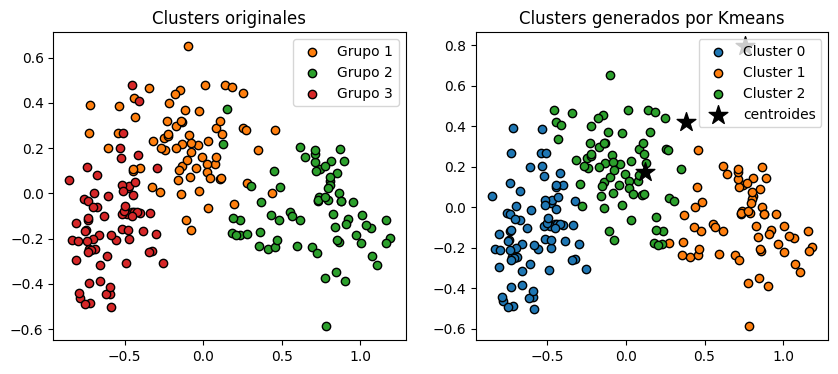

In [65]:
plot_predictions(X_reduced, y, modelo_kmeans)

In [43]:
pd.crosstab(y, y_predict, dropna=False, rownames=['g_real'], colnames=['g_cluster'])

g_cluster,0,1,2,3
g_real,,,,
1,2,0,26,42
2,0,51,19,0
3,62,0,0,8


Nos detecta 4 agrupaciones. No es lo que se espera, por lo que vamos a probar:

- CODO
- SILUETA

#### CODO

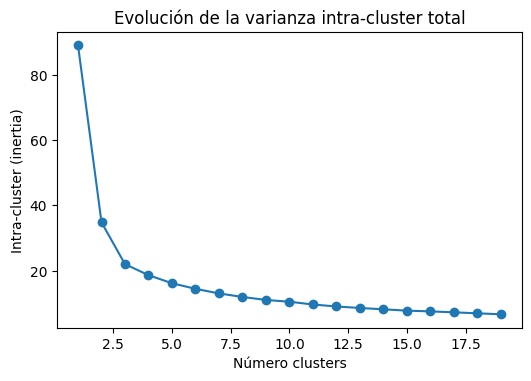

In [44]:
range_n_clusters = range(1, 20)
inertias = []

for n_clusters in range_n_clusters:
    modelo_kmeans = KMeans(
        n_clusters   = n_clusters,
        n_init       = 20,
        random_state = SEED
    )
    modelo_kmeans.fit(X_scaled)
    inertias.append(modelo_kmeans.inertia_)

fig, ax = plt.subplots(1, 1, figsize=(6, 3.84))
ax.plot(range_n_clusters, inertias, marker='o')
ax.set_title("Evolución de la varianza intra-cluster to tal")
ax.set_xlabel('Número clusters')
ax.set_ylabel('Intra-cluster (inertia)');

Se obtiene que `k_clusters` tiene un ideal entre 3-4. Pero como es difícil de comprender, se probará otro método.

#### SILUETA

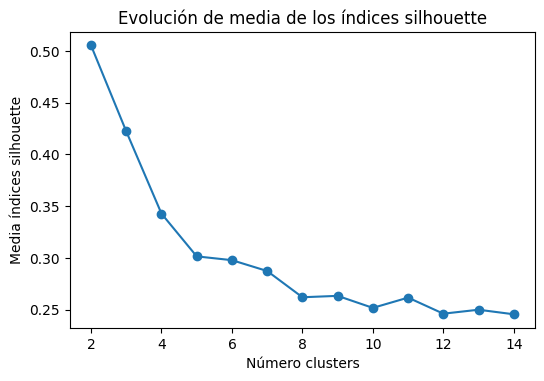

In [45]:
range_n_clusters = range(2, 15)
valores_medios_silhouette = []

for n_clusters in range_n_clusters:
    modelo_kmeans = KMeans(
        n_clusters   = n_clusters,
        n_init       = 20,
        random_state = 123
    )
    cluster_labels = modelo_kmeans.fit_predict(X_scaled)
    silhouette_avg = silhouette_score(X_scaled, cluster_labels)
    valores_medios_silhouette.append(silhouette_avg)

fig, ax = plt.subplots(1, 1, figsize=(6, 3.84))
ax.plot(range_n_clusters, valores_medios_silhouette, marker='o')
ax.set_title("Evolución de media de los índices silhouette")
ax.set_xlabel('Número clusters')
ax.set_ylabel('Media índices silhouette');